### Predict sales ###

predict number of sold items next month

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import(mean_squared_error)
import seaborn as sns

In [2]:
# read csv files into DataFrame
path="C:/Users/User/Desktop/projekti_zadnje/predikcija_prodaje/"
train=pd.read_csv(path+"sales_train.csv")
sample_submission=pd.read_csv(path+"sample_submission.csv")
test_data=pd.read_csv(path+"test.csv")

In [4]:
print(train.head(10))   # we have minus values
train.date_block_num.max()  # starting with 0, we have 34 months of data

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0


33

In [5]:
print(train.info())
pd.set_option('display.float_format', lambda x: '%.3f' % x)   #  so the output will be float a not exponentials
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
       date_block_num     shop_id     item_id  item_price  item_cnt_day
count     2935849.000 2935849.000 2935849.000 2935849.000   2935849.000
mean           14.570      33.002   10197.227     890.853         1.243
std             9.423      16.227    6324.297    1729.800         2.619
min             0.000       0.000       0.000      -1.000       -22.000
25%             7.000      22.000    4476.000     249.000         1.000
50%            14.000      31.000    9343.000     399.000         1.000
75%            23.000      47.000   15684.000     999.000         1.000
max        

<AxesSubplot:xlabel='item_price'>

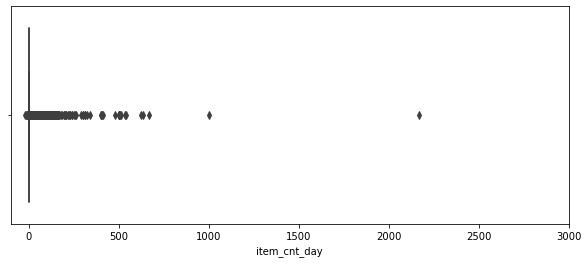

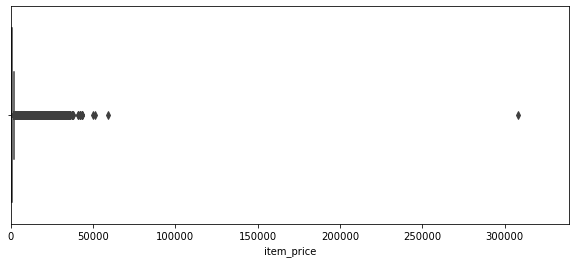

In [6]:
# inspect for outliers

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)                                          # remove items with price > 100000 and sales > 1000

In [3]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

In [4]:
print((train['item_cnt_day']< 0).sum().sum())   #  count negative values
print((train['item_price']< 0).sum().sum())  
train['item_cnt_day'].clip(lower=0,inplace=True)
train['item_price'].clip(lower=0,inplace=True)  # there are negative values, so wee will set them to zero

7356
1


In [5]:
print('train shape',train.shape)
print('test shape',test_data.shape)      # Test set is a product of some shops and some items within 34 month, There are 5100 items * 42 shops = 214200 pairs

# 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero.
#  In the other hand train set contains only pairs which were sold or returned in the past.

train shape (2935846, 6)
test shape (214200, 3)


In [76]:
print(train.isnull().sum())
print(train.isna().sum())


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [10]:
print(test_data.head(10))
test_data.info()


   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5     5041
7   7        5     5046
8   8        5     5319
9   9        5     5003
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [6]:
# drop column we don't need
train.drop(['date_block_num','item_price'], axis=1, inplace=True)

In [7]:
# change date column
train['date'] = pd.to_datetime(train['date'], dayfirst=True)
train['date'] = train['date'].apply(lambda x: x.strftime('%Y-%m'))
train.head()

,date,shop_id,item_id,item_cnt_day
0,2013-01,59,22154,1.0
1,2013-01,25,2552,1.0
2,2013-01,25,2552,0.0
3,2013-01,25,2554,1.0
4,2013-01,25,2555,1.0


In [14]:
# create a pivot table so we get our data in desired form 
# we want get total count value of an item over the whole month for a shop

df = train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)
df.head().T

,0,1,2,3,4
date,,,,,
shop_id,0,0,0,0,0
item_id,30,31,32,33,35
2013-01,0,0,6,3,1
2013-02,31,11,10,3,14
2013-03,0,0,0,0,0
2013-04,0,0,0,0,0
2013-05,0,0,0,0,0
2013-06,0,0,0,0,0
2013-07,0,0,0,0,0


In [9]:
# Now we will merge our pivot table with the test_data because we want to keep the data of items we have
df_test = pd.merge(test_data, df, on=['shop_id','item_id'], how='left')
df_test.drop(['ID', '2013-01'], axis=1, inplace=True)   # drop columns we don't need
df_test = df_test.fillna(0)              # there are additional items so we need to fill with zero
df_test.head().T

,0,1,2,3,4
shop_id,5.0,5.0,5.0,5.0,5.0
item_id,5037.0,5320.0,5233.0,5232.0,5268.0
2013-02,0.0,0.0,0.0,0.0,0.0
2013-03,0.0,0.0,0.0,0.0,0.0
2013-04,0.0,0.0,0.0,0.0,0.0
2013-05,0.0,0.0,0.0,0.0,0.0
2013-06,0.0,0.0,0.0,0.0,0.0
2013-07,0.0,0.0,0.0,0.0,0.0
2013-08,0.0,0.0,0.0,0.0,0.0
2013-09,0.0,0.0,0.0,0.0,0.0


In [15]:
# split the dataset
  
X = df[df.columns[:-1]]   # all features except last column
y = df[df.columns[-1]]   # last column is label


X_test_sub= df_test

print(X.shape,y.shape,X_test_sub.shape)


(424123, 35) (424123,) (214200, 35)


In [16]:
# Separate the dataset into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(339298, 35)
(84825, 35)
(339298,)
(84825,)


In [17]:
# helper function, evaluate models

def evaluate_model(model):
    RMSE_train = mean_squared_error(y_train, model.predict(X_train))
    RMSE_test = mean_squared_error(y_test, model.predict(X_test))
    
    print('Train set mse:', RMSE_train)
    print('Test set mse:', RMSE_test)
    print('Train set score:', model.score(X_train,y_train))
    
    return RMSE_train, RMSE_test

In [18]:
# Linear regression

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)


RMSE_train_lr,RMSE_test_lr = evaluate_model(lr)

# time of completion 0 minutes and 2 seconds, but accuracy is low

Train set mse: 1.5735658128892571
Test set mse: 4.552606710098722
Train set score: 0.5237177590542978


In [19]:
# Logistic regression

from sklearn.linear_model import LogisticRegression
log = LogisticRegression().fit(X_train, y_train)

RMSE_train_log, RMSE_test_log = evaluate_model(log)

# time of completion 4 minutes and 58 seconds

c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set mse: 3.330028470548014
Test set mse: 7.327285587975243
Train set score: 0.925708374349392


In [20]:
# Random forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train,y_train)

RMSE_train_rf, RMSE_test_rf = evaluate_model(rf)

# time of completion 6 minutes and 58 seconds

Train set mse: 0.20126582591114592
Test set mse: 4.14893058178603
Train set score: 0.9390814557576471


In [21]:
# Stochastic Gradient Descent 

from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier().fit(X_train, y_train)

RMSE_train_sgdc, RMSE_test_sgdc = evaluate_model(sgdc)

# time of completion 7 minutes and 38 seconds

Train set mse: 8.56262931110705
Test set mse: 11.732166224580018
Train set score: 0.9039133740841384


In [48]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=16,n_estimators=200,seed=1,objective='count:poisson')   # added this objective because model predicted some negative values
xgb.fit(X_train,y_train)

RMSE_train_xgb, RMSE_test_xgb = evaluate_model(xgb)

# time 4 minutes and 7 seconds

Train set mse: 0.008024075272068972
Test set mse: 4.465808067642674
Train set score: 0.9975712966557905


In [49]:
# see which model is the best
df_models_acc = pd.DataFrame({
    'Model': ['lr','log', 'rf', 'sgd','xgb'],
    'RMSE_Train': [RMSE_train_lr,RMSE_train_log, RMSE_train_rf, RMSE_train_sgdc,RMSE_train_xgb],
    'RMSE_Test': [RMSE_test_lr,RMSE_test_log, RMSE_test_rf, RMSE_test_sgdc,RMSE_test_xgb],
})
df_models_acc.sort_values(by='RMSE_Train')

,Model,RMSE_Train,RMSE_Test
4,xgb,0.008024,4.465808
2,rf,0.201266,4.148931
0,lr,1.573566,4.552607
1,log,3.330028,7.327286
3,sgd,8.562629,11.732166


In [ ]:
# Since XGBRegressor gets the best results, it will be used for the submission.

In [50]:
prediction = xgb.predict(X_test_sub)

prediction = list(map(round, prediction))   #  values are decimals so we round them

print(prediction[:50])
print(len(prediction))



[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0]
214200


In [51]:
# Submission

submission = sample_submission.drop('item_cnt_month', axis=1)
submission['item_cnt_month'] = prediction
submission.head(10)

,ID,item_cnt_month
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,2


In [52]:
print(submission['item_cnt_month'].unique())

from collections import Counter 
print(Counter(submission['item_cnt_month']))

[  0   2   1   3   4  12   8  18  11  57  20   6   5  19  70  14  10  59
  24  49  53  25   7   9  23  15  17  21  28  55  16  27  81  29 231  36
  13  42  43 266  39  47  35  97  88 120  34  33  31  22  64 124  30  40
  61  37  58  45  32 232  26  41  62  90  52  46  56  50  65  77  94  82
 133]
Counter({0: 176304, 1: 32306, 2: 3236, 3: 934, 4: 451, 5: 199, 6: 130, 7: 95, 8: 76, 9: 49, 12: 42, 10: 42, 11: 38, 15: 34, 13: 31, 14: 27, 18: 20, 16: 17, 20: 16, 19: 15, 17: 12, 21: 10, 28: 10, 29: 7, 33: 7, 24: 6, 23: 5, 59: 4, 25: 4, 43: 4, 35: 4, 31: 4, 22: 4, 26: 4, 70: 3, 27: 3, 39: 3, 64: 3, 57: 2, 49: 2, 55: 2, 81: 2, 42: 2, 34: 2, 53: 1, 231: 1, 36: 1, 266: 1, 47: 1, 97: 1, 88: 1, 120: 1, 124: 1, 30: 1, 40: 1, 61: 1, 37: 1, 58: 1, 45: 1, 32: 1, 232: 1, 41: 1, 62: 1, 90: 1, 52: 1, 46: 1, 56: 1, 50: 1, 65: 1, 77: 1, 94: 1, 82: 1, 133: 1})
